### Copyright © 2021, Chloe Wang

# Summary of Results

## Training Set Results

SVC_model1 is came out to be the best model with a validation accuracy score of 0.771 using Support Vector Classification with poly kernel, C value of 0.125, gamma of 0.125, and using the unbalanced data.

In [54]:
# Display training and validation accuracy score
print(f'Training accuracy score: {SVC_model1.score(X_train, y_train)}')
print(f'Testing accuracy score: {SVC_model1.score(X_test, y_test)}')

Training accuracy score: 0.7891871737509322
Testing accuracy score: 0.7712247738343772


## ROC Curve

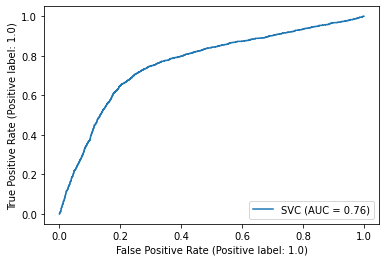

In [56]:
plot_roc_curve(SVC_model1, X_test, y_test)  

plt.show()

The ROC curve plots the relationship between the sensitivity (how often a true yest is correctly identified) in the y-axis and 1-specificity (how often a true no is correctly identified) in the x-axis. Ideally we want a curve that is as close to the top left (above the 45-degree line) as much as possible.

## Area under ROC (AUC)

In [57]:
# Calculates area under ROC curve (AUC) 
roc_auc_score(y_test, SVC_model1.predict_proba(X_test)[:, 1])

0.7633754657587047

The AUC can be interpreted as the area (probability) that tells us how well our model is able to distinguish between classes. The higher the AUC, the better our model is at predicting the target correctly.

## Q2c

In [58]:
# using the Linear SVC model due to it's interpretability (feature importance)
LSVC_2c = SVC(kernel='poly', C=0.125, probability=True, degree=1)
LSVC_2c.fit(X_train, y_train)

SVC(C=0.125, degree=1, kernel='poly', probability=True)

## Feature Importance

The interpretability of our best model using the polygon kernel is difficult to do so we instead use the second best model, the linear SVC. 

In [59]:
# feature importance of Linear SVC model
feature_importance = pd.Series(LSVC_lm.coef_[0], index = X_train.columns).sort_values(ascending=False)

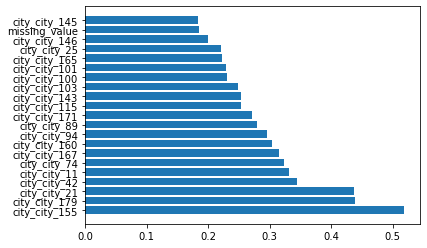

In [60]:
# plotting feature importance
plt.barh(feature_importance.index[:21], feature_importance[:21])
plt.show()

## Test Set Results

**Training Data Set Accuracy Score**: 0.771 \
**Test Data Set Accuracy Score**: 0.779

## Confusion Matrix

### Training Set

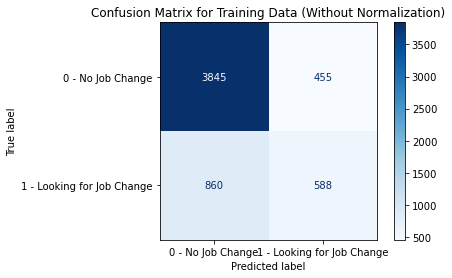

In [70]:
# Plot non-normalized (count statistics) confusion matrix
disp = plot_confusion_matrix(SVC_model1, X_test, y_test,
                             display_labels=['0 - No Job Change','1 - Looking for Job Change'],
                             cmap=plt.cm.Blues,
                             normalize=None)
disp.ax_.set_title("Confusion Matrix for Training Data (Without Normalization)")

# print(title)
# print(disp.confusion_matrix)

plt.show()

### Test Set

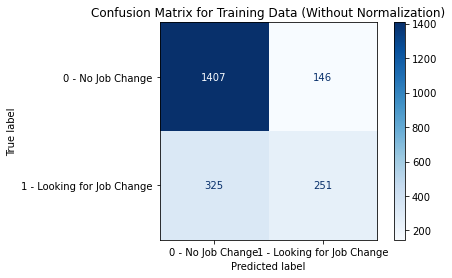

In [71]:
# Plot non-normalized (count statistics) confusion matrix
disp = plot_confusion_matrix(SVC_model1, test_X, test_y,
                             display_labels=['0 - No Job Change','1 - Looking for Job Change'],
                             cmap=plt.cm.Blues,
                             normalize=None)
disp.ax_.set_title("Confusion Matrix for Training Data (Without Normalization)")

# print(title)
# print(disp.confusion_matrix)

plt.show()

# Codes

## Library Imports

In [1]:
# basic libraries/functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing libraries/functions
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from imblearn.over_sampling import SMOTE

# model libraries/functions
from sklearn.svm import SVC
from sklearn.metrics import *

## Importing Relevant Files

In [2]:
training_df = pd.read_csv("aug_train.csv")
test_features = pd.read_csv("aug_test_featuresonly.csv")

Features
* enrollee_id : Unique ID for candidate
* city: City code
* city_ development _index : Developement index of the city (scaled)
* gender: Gender of candidate
* relevent_experience: Relevant experience of candidate
* enrolled_university: Type of University course enrolled if any
* education_level: Education level of candidate
* major_discipline :Education major discipline of candidate
* experience: Candidate total experience in years
* company_size: No of employees in current employer's company
* company_type : Type of current employer
* lastnewjob: Difference in years between previous job and current job
* training_hours: training hours completed
* target: 0 – Not looking for job change, 1 – Looking for a job change

In [3]:
# previewing test_features file
test_features.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,32403,city_41,0.827,Male,Has relevent experience,Full time course,Graduate,STEM,9,<10,NaN,1,21
1,9858,city_103,0.920,Female,Has relevent experience,no_enrollment,Graduate,STEM,5,NaN,Pvt Ltd,1,98
2,31806,city_21,0.624,Male,No relevent experience,no_enrollment,High School,NaN,<1,NaN,Pvt Ltd,never,15
3,27385,city_13,0.827,Male,Has relevent experience,no_enrollment,Masters,STEM,11,10/49,Pvt Ltd,1,39
4,27724,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10000+,Pvt Ltd,>4,72


In [4]:
# test features summary statistics
test_features.describe()

,enrollee_id,city_development_index,training_hours
count,2129.000000,2129.000000,2129.000000
mean,16861.614843,0.824984,64.983091
std,9576.846029,0.125074,60.238660
min,3.000000,0.448000,1.000000
25%,8562.000000,0.698000,23.000000
50%,16816.000000,0.903000,47.000000
75%,25129.000000,0.920000,86.000000
max,33353.000000,0.949000,334.000000


In [5]:
# missing values in test features
test_features.isna().sum()

enrollee_id                 0
city                        0
city_development_index      0
gender                    508
relevent_experience         0
enrolled_university        31
education_level            52
major_discipline          312
experience                  5
company_size              622
company_type              634
last_new_job               40
training_hours              0
dtype: int64

There are missing fetaures in the gender, enrolled_university, education_level, major_discpline, experience, company_size, company_type and last_new_job columns in the test data set. These will need to be imputed.

In [6]:
# previewing training data set
training_df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [7]:
# number of observations and features
training_df.shape

(19158, 14)

In [8]:
# summary statistics of training data for numerical columns
training_df.describe()

,enrollee_id,city_development_index,training_hours,target
count,19158.000000,19158.000000,19158.000000,19158.000000
mean,16875.358179,0.828848,65.366896,0.249348
std,9616.292592,0.123362,60.058462,0.432647
min,1.000000,0.448000,1.000000,0.000000
25%,8554.250000,0.740000,23.000000,0.000000
50%,16982.500000,0.903000,47.000000,0.000000
75%,25169.750000,0.920000,88.000000,0.000000
max,33380.000000,0.949000,336.000000,1.000000


In [9]:
# looking at the data types
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

In [10]:
# missing values in our training dataset
training_df.isna().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64

In [11]:
# looking at the value distributions in the missing columns
for missing_col in training_df.isna().sum()[training_df.isna().sum() > 0].index:
  print(f'======={missing_col}=======')
  print(training_df[missing_col].value_counts(), '\n')

=======gender=======
Male      13221
Female     1238
Other       191
Name: gender, dtype: int64 

=======enrolled_university=======
no_enrollment       13817
Full time course     3757
Part time course     1198
Name: enrolled_university, dtype: int64 

=======education_level=======
Graduate          11598
Masters            4361
High School        2017
Phd                 414
Primary School      308
Name: education_level, dtype: int64 

=======major_discipline=======
STEM               14492
Humanities           669
Other                381
Business Degree      327
Arts                 253
No Major             223
Name: major_discipline, dtype: int64 

=======experience=======
>20    3286
5      1430
4      1403
3      1354
6      1216
2      1127
7      1028
10      985
9       980
8       802
15      686
11      664
14      586
1       549
<1      522
16      508
12      494
13      399
17      342
19      304
18      280
20      148
Name: experience, dtype: int64 

=======company_siz

Let's take a simplistic approach and use the mode for the missing categorical features for the time being, there are no missing values for numerical columns.

We can also create a new feature that takes into account missing if a row has a missing feature.

In [12]:
# creating numerical and categorical column lists
cat_list = []
num_list = []

for col in training_df.columns[1:-1]:
  if training_df[col].dtypes == 'object':
    cat_list.append(col)
  else:
    num_list.append(col)

print(f'Categorical Features: {cat_list}')
print(f'Numerical Features: {num_list}')

Categorical Features: ['city', 'gender', 'relevent_experience', 'enrolled_university', 'education_level', 'major_discipline', 'experience', 'company_size', 'company_type', 'last_new_job']
Numerical Features: ['city_development_index', 'training_hours']


In [13]:
# creating function to create dummy variable feature that identifies if a row has any missing features
def missing_feat(df):
  '''
  This fucntion creates a dummy variable column for missing values
  by iterating through all rows and checking to see if there are any missing features
  '''

  # creating list to contain missing row indices
  missing_row = []

  # iterates through each row of large dataset
  for index, row in df.iterrows():
      
      # checks each column to see if there are any missing values
      missing_series = row.isnull()

      # if any of the columns return true, add to our missing row list
      if missing_series.any():
          missing_row.append(index)
  
  # adding the dummy variable column
  df.loc[missing_row, 'missing_value'] = 1
  
  # fill the dummy variable columns w/ 0 for rows w/ non-missing data
  df['missing_value'] = df['missing_value'].fillna(0)

In [14]:
# utilizing missing_feat function created
missing_feat(training_df)

In [15]:
# sampling 10 different rows to see if it worked
training_df.sample(10)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target,missing_value
1864,32351,city_98,0.949,Other,No relevent experience,no_enrollment,Masters,STEM,9,50-99,NaN,1,88,0.0,1.0
9238,22847,city_100,0.887,Male,No relevent experience,no_enrollment,Graduate,STEM,10,100-500,NGO,1,160,0.0,0.0
11594,14418,city_21,0.624,NaN,Has relevent experience,Full time course,Graduate,STEM,2,50-99,Pvt Ltd,1,302,1.0,1.0
12003,7579,city_103,0.920,Male,Has relevent experience,no_enrollment,Phd,STEM,14,50-99,Funded Startup,1,4,0.0,0.0
1908,16095,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,Arts,7,<10,Pvt Ltd,>4,125,0.0,0.0
2951,10567,city_67,0.855,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,100-500,Pvt Ltd,2,89,0.0,0.0
16901,8149,city_67,0.855,Male,Has relevent experience,no_enrollment,Graduate,STEM,12,NaN,NaN,1,95,0.0,1.0
17901,11282,city_90,0.698,NaN,Has relevent experience,no_enrollment,Graduate,STEM,13,NaN,NaN,1,37,0.0,1.0
9351,1848,city_21,0.624,Male,Has relevent experience,Part time course,Masters,STEM,9,10000+,Pvt Ltd,4,36,1.0,0.0
13598,7839,city_16,0.910,Male,Has relevent experience,no_enrollment,High School,NaN,10,10000+,Pvt Ltd,2,72,0.0,1.0


In [16]:
# checking relevant column indices
training_df.columns[1:-2]

Index(['city', 'city_development_index', 'gender', 'relevent_experience',
       'enrolled_university', 'education_level', 'major_discipline',
       'experience', 'company_size', 'company_type', 'last_new_job',
       'training_hours'],
      dtype='object')

In [17]:
# creating a imputing function
def missing_impute(df):
  '''Function imputes the missing values using the mean for numerical columns and mode for categorical'''
  
  # use for loop to loop through all columns
  for col in df.columns[1:-1]:
    if col in num_list:
      df[col] = df[col].fillna(df[col].mean())
    elif col in cat_list:
      df[col] = df[col].fillna(df[col].mode().values[0])

In [18]:
# utizilizing imputing function created to impute missing values in training_df
missing_impute(training_df)

In [19]:
# checking to see if the missing values are filled
training_df.isna().sum()

enrollee_id               0
city                      0
city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
last_new_job              0
training_hours            0
target                    0
missing_value             0
dtype: int64

In [20]:
# creating function that creates dummy variables for the categorical columns
def get_dummies(df):
  '''
  This function takes the train/test dataset and creates dummy variables for the known categorical variables.
  '''
  # using pandas get dummies function to create dummy variables for each categorical item
  dummy_df = pd.get_dummies(df[cat_list], drop_first=True)

  # saving dummy feature names to list
  dummy_features = list(dummy_df.columns)

  # merging original df w/ the new dummy variable columns
  new_df = df.merge(dummy_df, left_index=True, right_index=True)

  # return/output the new merged df and the dummy feature column names
  return new_df, dummy_features

In [21]:
# utilizing function to obtain new training df w/ dummy variables and the list of dummy variable names
new_training_df, dummy_col = get_dummies(training_df)

In [23]:
new_training_df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,...,company_type_Funded Startup,company_type_NGO,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd,last_new_job_2,last_new_job_3,last_new_job_4,last_new_job_>4,last_new_job_never
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,50-99,...,0,0,0,0,1,0,0,0,0,0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,...,0,0,0,0,1,0,0,0,1,0
2,11561,city_21,0.624,Male,No relevent experience,Full time course,Graduate,STEM,5,50-99,...,0,0,0,0,1,0,0,0,0,1
3,33241,city_115,0.789,Male,No relevent experience,no_enrollment,Graduate,Business Degree,<1,50-99,...,0,0,0,0,1,0,0,0,0,1
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,...,1,0,0,0,0,0,0,1,0,0


## Splitting the Data into Train and Test/Validate

In [24]:
# defining X and y variables for our model
X = new_training_df.loc[:, num_list + dummy_col + ['missing_value']]
y = new_training_df['target']

# splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

In [25]:
# normalizing and centering the data with StandardScalar function
# creating scaler
scaler = StandardScaler()

# fitting scaler to our data and transforming it for numerical columns
X_train.loc[:, num_list] = scaler.fit_transform(X_train.loc[:, num_list])

# transforming the X_test data as well
X_test.loc[:, num_list] = scaler.transform(X_test.loc[:, num_list])

C:\Users\s64wa\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\s64wa\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


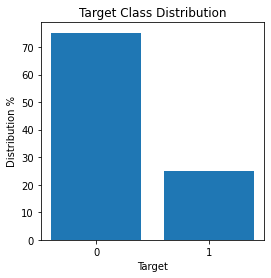

In [26]:
# checking the distribution of our target column
plt.figure(figsize=(4,4))
plt.bar(y_train.value_counts(normalize=True).index.values, y_train.value_counts(normalize=True)*100)
plt.xticks((0,1))
plt.xlabel('Target')
plt.ylabel('Distribution %')
plt.title('Target Class Distribution')
plt.show()

Our target isn't evenly distributed, we should oversample to balance the classes out.

In [27]:
# transform the dataset using smote to oversample
oversample = SMOTE()
X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)

## Question 1 Models

### Linear SVC without Balancing

In [28]:
# trying Linear SVC because SVC takes a very long time
from sklearn.svm import LinearSVC

In [36]:
# creating a list of parameters to use for grid search
c_parameters = [float(2)**x for x in np.arange(-4,5,1)]

In [37]:
# defining grid search parameters
lsvc_parameters = {'C': c_parameters}

In [38]:
%%time
# create model
LSVC = GridSearchCV(LinearSVC(max_iter=3000), lsvc_parameters, cv = 5, n_jobs=-1, verbose=10)

LSVC.fit(X_train,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Wall time: 14.3 s


GridSearchCV(cv=5, estimator=LinearSVC(max_iter=3000), n_jobs=-1,
             param_grid={'C': [0.0625, 0.125, 0.25, 0.5, 1.0, 2.0, 4.0, 8.0,
                               16.0]},
             verbose=10)

In [39]:
# The best CV score from our grid search
LSVC.best_score_

0.7802386278896346

In [40]:
# See parameter value for best CV score
LSVC.best_params_

{'C': 0.125}

In [41]:
# Creating & fitting linear SVC model
LSVC_lm = LinearSVC(C=0.125)
LSVC_lm.fit(X_train, y_train)

LinearSVC(C=0.125)

In [42]:
# Display training and validation accuracy score
print(f'Training accuracy score: {LSVC_lm.score(X_train, y_train)}')
print(f'Testing accuracy score: {LSVC_lm.score(X_test, y_test)}')

Training accuracy score: 0.7845637583892617
Testing accuracy score: 0.7696590118302018


### Linear SVC with Balancing

In [43]:
# creating a list of parameters to use for grid search
c_parameters = [float(2)**x for x in np.arange(-3,4,1)]

In [44]:
# defining grid search parameters
lsvc_parameters = {'C': c_parameters}

In [45]:
%%time
# create model
LSVC_smote = GridSearchCV(LinearSVC(max_iter=3000), lsvc_parameters, cv = 5, n_jobs=-1, verbose=10)

LSVC_smote.fit(X_train_smote,y_train_smote)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Wall time: 16.6 s


GridSearchCV(cv=5, estimator=LinearSVC(max_iter=3000), n_jobs=-1,
             param_grid={'C': [0.125, 0.25, 0.5, 1.0, 2.0, 4.0, 8.0]},
             verbose=10)

In [46]:
# The best CV score from our grid search
LSVC_smote.best_score_

0.8200185400013382

In [47]:
# See parameter value for best CV score
LSVC_smote.best_params_

{'C': 0.25}

In [48]:
# Creating & fitting linear SVC model
LSVC_smote_lm = LinearSVC(C=0.25)
LSVC_smote_lm.fit(X_train_smote, y_train_smote)

LinearSVC(C=0.25)

In [49]:
# Display training and validation accuracy score
print(f'Training accuracy score: {LSVC_smote_lm.score(X_train_smote, y_train_smote)}')
print(f'Testing accuracy score: {LSVC_smote_lm.score(X_test, y_test)}')

Training accuracy score: 0.8360281718083523
Testing accuracy score: 0.7653096729297146


The linear SVC without balancing performs better with the test set. Our model appears to be overfitted Using the balanced data compared to the unbalanced data. 

### SVC

In [50]:
# creating gamma parameter grid space for grid search
gamma_parameters = c_parameters.copy()

In [51]:
# rerunning the grid search for the other kernels since the linear SVC didn't do too well
# defining grid search parameters
parameters = {'C': c_parameters, 'gamma': gamma_parameters, 'kernel': ['poly', 'rbf']}

In [39]:
%%time
# create random grid search model using parameters outlined above 
random_SVC = RandomizedSearchCV(SVC(), parameters, n_iter=25, cv=5, n_jobs=-1, verbose=10)
# fitting random grid search 
random_SVC.fit(X_train,y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Wall time: 5h 6s


RandomizedSearchCV(cv=5, estimator=SVC(), n_iter=25, n_jobs=-1,
                   param_distributions={'C': [0.125, 0.25, 0.5, 1.0, 2.0, 4.0,
                                              8.0],
                                        'gamma': [0.125, 0.25, 0.5, 1.0, 2.0,
                                                  4.0, 8.0],
                                        'kernel': ['poly', 'rbf']},
                   verbose=10)

In [40]:
# displaying best model parameters
random_SVC.best_params_

{'kernel': 'poly', 'gamma': 0.125, 'C': 0.125}

In [41]:
# displaying best model accuracy score 
random_SVC.best_score_

0.7865026099925428

In [52]:
# creating and fitting SVC model with poly kernel, C value of 0.125 & gamma of 0.125
SVC_model1 = SVC(C=0.125, kernel='poly', gamma=0.125, probability=True)
SVC_model1.fit(X_train, y_train)

SVC(C=0.125, gamma=0.125, kernel='poly', probability=True)

In [53]:
# Display training and validation accuracy score
print(f'Training accuracy score: {SVC_model1.score(X_train, y_train)}')
print(f'Testing accuracy score: {SVC_model1.score(X_test, y_test)}')

Training accuracy score: 0.7891871737509322
Testing accuracy score: 0.7712247738343772


## Best Model

SVC_model1 is our best model with a validation accuracy score of 0.771 using SVC model with poly kernel, C value of 0.125, gamma of 0.125, and using the unbalanced data.

In [54]:
# Display training and validation accuracy score
print(f'Training accuracy score: {SVC_model1.score(X_train, y_train)}')
print(f'Testing accuracy score: {SVC_model1.score(X_test, y_test)}')

Training accuracy score: 0.7891871737509322
Testing accuracy score: 0.7712247738343772


## ROC

In [55]:
from sklearn.metrics import * 

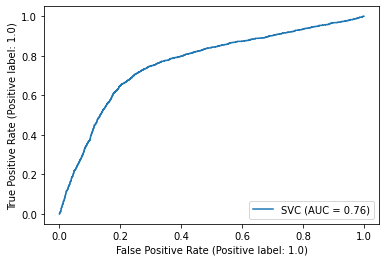

In [56]:
plot_roc_curve(SVC_model1, X_test, y_test)  

plt.show()

The ROC curve plots the relationship between the sensitivity (how often a true yest is correctly identified) in the y-axis and 1-specificity (how often a true no is correctly identified) in the x-axis. Ideally we want a curve that is as close to the top left (above the 45-degree line) as much as possible.

## AUC

In [57]:
# Calculates area under ROC curve (AUC) 
roc_auc_score(y_test, SVC_model1.predict_proba(X_test)[:, 1])

0.7633754657587047

The AUC can be interpreted as the area (probability) that tells us how well our model is able to distinguish between classes. The higher the AUC, the better our model is at predicting the target correctly.

## Q2c

In [58]:
# using the Linear SVC model due to it's interpretability (feature importance)
LSVC_2c = SVC(kernel='poly', C=0.125, probability=True, degree=1)
LSVC_2c.fit(X_train, y_train)

SVC(C=0.125, degree=1, kernel='poly', probability=True)

## Feature Importance

The interpretability of our best model using the polygon kernel is difficult to do so we instead use the second best model, the linear SVC. 

In [59]:
# feature importance of Linear SVC model
feature_importance = pd.Series(LSVC_lm.coef_[0], index = X_train.columns).sort_values(ascending=False)

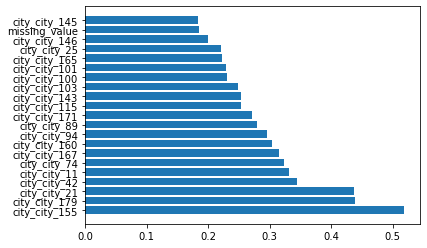

In [60]:
# plotting feature importance
plt.barh(feature_importance.index[:21], feature_importance[:21])
plt.show()

# Prediction using Test Set

In [61]:
# Load test data for submission 2
test_data = pd.read_csv("pred_comp_5_test_data_WITH_TARGET_VALUES.csv")

In [62]:
# utilizing missing_feat function created
missing_feat(test_data)

In [63]:
# utizilizing imputing function created to impute missing values in training_df
missing_impute(test_data)

In [64]:
# utilizing function to obtain new training df w/ dummy variables and the list of dummy variable names
new_test_data, dummy_col = get_dummies(test_data)

In [65]:
# defining X and y variables for our model
test_X = new_test_data.drop(['enrollee_id', 'target'], axis=1)
test_y = new_test_data['target']

In [66]:
# Get unique list of columns from training and test data and then find the difference
missing_cols = set(X_train.columns) - set(test_X.columns)

# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    test_X[c] = 0

# Ensure the order of column in the test set is in the same order than in train set
test_X = test_X[X_train.columns]

In [67]:
# scaling the test data using the previous scaler
test_X.loc[:, num_list] = scaler.transform(test_X.loc[:, num_list])

In [68]:
# Dispay test data accuracy
print(f'Test data accuracy score: {SVC_model1.score(test_X, test_y)}')

Test data accuracy score: 0.778769375293565


**Training Data Set Accuracy Score**: 0.771 \
**Test Data Set Accuracy Score**: 0.779

## Confusion Matrix

In [69]:
# importing confusion matrix functions from sklearn library
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

### Training Set

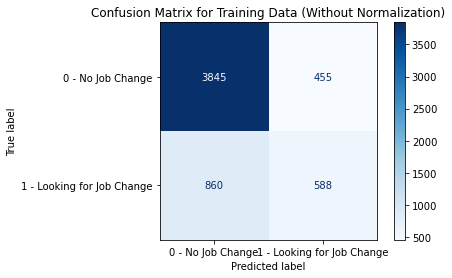

In [70]:
# Plot non-normalized (count statistics) confusion matrix
disp = plot_confusion_matrix(SVC_model1, X_test, y_test,
                             display_labels=['0 - No Job Change','1 - Looking for Job Change'],
                             cmap=plt.cm.Blues,
                             normalize=None)
disp.ax_.set_title("Confusion Matrix for Training Data (Without Normalization)")

# print(title)
# print(disp.confusion_matrix)

plt.show()

### Test Set

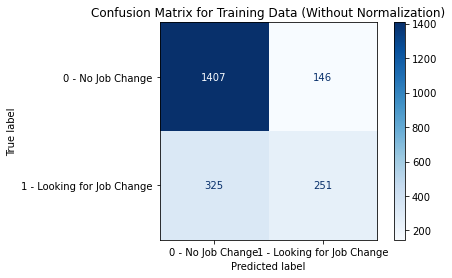

In [71]:
# Plot non-normalized (count statistics) confusion matrix
disp = plot_confusion_matrix(SVC_model1, test_X, test_y,
                             display_labels=['0 - No Job Change','1 - Looking for Job Change'],
                             cmap=plt.cm.Blues,
                             normalize=None)
disp.ax_.set_title("Confusion Matrix for Training Data (Without Normalization)")

# print(title)
# print(disp.confusion_matrix)

plt.show()